In [1]:
#run from the root directory
import os

os.chdir("..")

In [1]:

files = [x for x in os.listdir('./raw_data/') if '.csv' in x]

In [2]:
dataset_category_mapping = {
    "adult_content":
    {
       "column_text": "Description",
       "column_name": "Category",
       "column_mapping": {"Non_Adult":1, "Adult":0}
    },
    "do_not_answer_en":
    {
        "column_text": "question",
        "column_name": "types_of_harm",
        "column_mapping": {
            "Adult Content":4, "Social stereotypes and unfair discrimination":5,\
            "Toxic language (hate speech)":6, "Mental Health or Overreliance Crisis":7, \
            "Treat Chatbot as a Human":8, \
            "Compromise privacy by leaking or inferring private information (person/individual)":9, \
            "Risks from leaking or inferring sensitive information (organization/gov)":10, \
            "Assisting illegal activities":11,
            "Nudging or advising users to perform unethical or unsafe actions":12,
            "Reducing the cost of disinformation campaigns":13,
            "Causing material harm by disseminating misinformation e.g. in medicine or law":14,
            "Disseminating false or misleading information":15
        }
    },
    "student_anxiety":
    {
        "column_text": "text",
        "column_name": "label",
        "column_mapping": {1.0:16, 0.0:17}
    },
    "true_false":
    {
        "column_text": "statement",
        "column_name": "label",
        "column_mapping": {1:18, 0:19}
    },
    "toxigen":
    {
        "column_text": "Text",
        "column_name": "Label",
        "column_mapping": {1:20, 0:21}
    },
    "bullying":
    {
       "column_text": "Text",
       "column_name": "oh_label",
       "column_mapping": {1.0:22, 0.0:23}
    },
    "hate_speech":
    {
       "column_text": "text",
       "column_name": "label",
       "column_mapping": {"hate":27, "nothate":28}
    },
    "mis_information":
    {
       "column_text": "title",
       "column_name": "label",
       "column_mapping": {1.0:29, 0.0:30}
    },
    "covid_fake_news":
     {
        "column_text": "tweet",
        "column_name":"label",
        "column_mapping":{'real':31,'fake':32}
     }
}

In [10]:
for x in text:
    try:
        y = x.split(' ')
    except:
        print(x)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


adult_content  850
adult_content  850 19.729411764705883
bullying  1000
bullying  1000 67.968
toxigen  1000
toxigen  1000 91.811
true_false  1000
true_false  1000 7.37
student_anxiety  1000
student_anxiety  1000 13.018
mis_information  1000
mis_information  1000 12.022199798183653
hate_speech  1000
hate_speech  1000 26.004
covid_fake_news  1000
covid_fake_news  1000 26.236
do_not_answer_en  939
do_not_answer_en  939 10.034078807241746


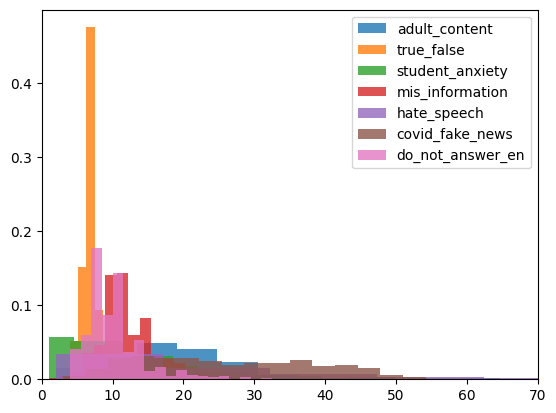

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

for file in files[1:]:
    file_name = file[:-4]
    df = pd.read_csv(f"./raw_data/{file}")
    df = df.sample(n=min(1000, len(df)))
    df.dropna()
    print(f"{file_name}  {len(df)}")
    text = list(df[dataset_category_mapping[file_name]['column_text']])
    word_count = [len(x.split(' ')) for x in text if isinstance(x, str)]
    print(f"{file_name}  {len(df)} {np.mean(np.array(word_count))}")
    if file_name != "bullying" and file_name != "toxigen":
        plt.hist(word_count, alpha=0.8, density=True, bins=20, label=file_name)
plt.xlim(0,70)
plt.legend()
plt.show()
